# Automatic Diagnosis Generation Given Chest X-rays EDA

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Reading-Data" data-toc-modified-id="Reading-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reading Data</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#Dataset-with-Findings-and-Impression-and-Images" data-toc-modified-id="Dataset-with-Findings-and-Impression-and-Images-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataset with Findings and Impression and Images</a></span></li><li><span><a href="#Exploratery-Data-Analysis" data-toc-modified-id="Exploratery-Data-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exploratery Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Images" data-toc-modified-id="Images-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Images</a></span></li><li><span><a href="#Impressions" data-toc-modified-id="Impressions-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Impressions</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#References" data-toc-modified-id="References-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>References</a></span></li></ul></div>

In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
drive_path = '/content/gdrive/My Drive/Assignments_Drive/Case_Study_2/Medical_Data'
# specifying paths
txt_path = drive_path + '/ecgen'
img_path = drive_path + '/images'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# this code is used to find the number of xml files in the data
from os import listdir
txt  = []
for name in listdir(txt_path):
    txt.append(name)
print('The number of text files are',len(txt))

# this code is used to find the number of image files in the data
img  = []
for name in listdir(img_path):
    img.append(name)
print('The number of image files are',len(img))

The number of text files are 3955
The number of image files are 7472


In [ ]:
#install beautifulsoup4 and lxml
! pip install beautifulsoup4
! pip install lxml

In [ ]:
# imports
import os
import re
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Reading Data

In [ ]:
# This function is used to open a text file
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [ ]:
# This code is used to read the xml file and then put it into an array
xml_files = os.listdir(txt_path)

# validating the desired results
print(xml_files)
print(len(xml_files))

['3691.xml', '3697.xml', '3682.xml', '3674.xml', '3685.xml', '37.xml', '3703.xml', '3702.xml', '3694.xml', '3664.xml', '368.xml', '367.xml', '3677.xml', '366.xml', '3724.xml', '3749.xml', '3709.xml', '3712.xml', '3734.xml', '3747.xml', '3718.xml', '3733.xml', '375.xml', '373.xml', '3716.xml', '3759.xml', '374.xml', '3720.xml', '3741.xml', '372.xml', '3729.xml', '3762.xml', '3736.xml', '3713.xml', '3764.xml', '3726.xml', '3750.xml', '3735.xml', '3705.xml', '3739.xml', '3719.xml', '3760.xml', '3710.xml', '3746.xml', '3763.xml', '3715.xml', '3721.xml', '3737.xml', '3745.xml', '3757.xml', '3728.xml', '3767.xml', '3758.xml', '3722.xml', '3730.xml', '3732.xml', '3766.xml', '3706.xml', '3717.xml', '3740.xml', '3742.xml', '3754.xml', '3748.xml', '3752.xml', '3708.xml', '376.xml', '3704.xml', '3751.xml', '3714.xml', '3765.xml', '3707.xml', '3744.xml', '3731.xml', '371.xml', '3755.xml', '3727.xml', '3743.xml', '3761.xml', '3738.xml', '3725.xml', '3753.xml', '3756.xml', '3723.xml', '378.xml', '37

In [ ]:
# now lets read each xml file and create a dataframe fron the data 

# rows th the dataframe
# 1. UID : The unique file id for each xml file
# 2. FINDINGS : The findings that the doctor writes after viewing the x-rays of the patient
# 3. Impressions : The final diagnosys that the doctor writes 
# 4. IMAGES : The list of images that are associated with a report

# This list will be used to used store the contents of each xml file
rows_list = []
for xmlfile in tqdm(xml_files):
    # file path stores the path of the xml files
    filepath = txt_path + '/' + xmlfile
    # this dict is used to contents of a xml file as {tag: value}
    dict_row = {}
    with open(filepath, "r") as f:
        # reading the file
        contents = f.read()
        # here we use lxml to parse the contents of xml file
        soup = BeautifulSoup(contents, 'lxml')
        # this piece of code is used to find the id associated with each file
        uid_tags = soup.findAll('uid')
        # extract the uid from tag and put the uid in the directory
        # this piece of code will check if there are more than one uids in the xml
        cnt = 0
        for ut in uid_tags:
            # increase cnt value
            cnt +=1
            # check if more than one ids are present
            if cnt > 1:
                # prit and break
                print('more than one ids')
                break
            # get the uid value
            file_id = ut.get('id')
            # put the value in the directory
            dict_row['UID'] = file_id
        # this piece of code extracts the text from the xml file where the tag is abstracttext  
        tags = soup.findAll(['abstracttext'])
        for t in tags:
            # extract labels
            label=t.get("label")

            # extract the FINDINGS 
            if label=='FINDINGS':
                f_text=t.text
                # put the values in a directory 
                dict_row['FINDINGS'] = f_text
                #lets add the no. of sentences 
                # first we need to add a fullstop to the end in case the doctor forgot to put it
                f_text = f_text + '.'
                f_sen = f_text.split('.')
                # array to store the sentences
                sent_arr = []
                for sent in f_sen:
                    # check if the sentence is blank
                    if sent != '':
                        # append the array
                        sent_arr.append(sent)
                # find no. of sentences 
                ns_findings = len(sent_arr)
                # add f_sen to the directory
                dict_row['NS_FINDINGS'] = ns_findings
            
            # extract the IMPRESSION 
            if label=='IMPRESSION':
                i_text=t.text
                # put the values in a directory 
                dict_row['IMPRESSION'] = i_text
                # lets add the no. of sentences 
                # first we need to add a fullstop to the end in case the doctor forgot to put it
                i_text = i_text + '.'
                i_sen = i_text.split('.')
                # array to store the sentences
                sent_arr = []
                for sent in i_sen:
                    # check if the sentence is blank
                    if sent != '':
                        # append the array
                        sent_arr.append(sent)
                # find no. of sentences 
                ns_impression = len(sent_arr)
                # add f_sen to the directory
                dict_row['NS_IMPRESSION'] = ns_impression

        # This piece of code will extract the image names from the XML files
        itags = soup.findAll(['parentimage'])
        # this array will hold the images in a xml file as there are more than one images in a xml file
        x_ray_images = []
        # for each image in the file we will put it in the array
        for element in itags:
            # extract the image name from the file
            x_ray = element.get('id')
            # append the array
            x_ray_images.append(x_ray)
        #finally put the array in the row dict
        dict_row['IMAGES'] = x_ray_images
        # lets find the no of images in a xml file
        no_images = len(x_ray_images)
        # add this to the dict
        dict_row['NO_IMAGES'] = no_images

    # append the dict to the row (for each xml file we will have a dict_row(dict of data) in the rows_list)
    rows_list.append(dict_row)

# finally create a dataframe from the rows_list
df = pd.DataFrame(rows_list)       

100%|██████████| 3955/3955 [00:27<00:00, 144.74it/s]


In [ ]:
print(df.shape)
df.head(10)

(3955, 7)


,UID,FINDINGS,NS_FINDINGS,IMPRESSION,NS_IMPRESSION,IMAGES,NO_IMAGES
0,CXR3691,The heart is normal in size. The mediastinum i...,5,No acute disease.,1,"[CXR3691_IM-1842-1001, CXR3691_IM-1842-3003]",2
1,CXR3697,The cardiomediastinal silhouette is stable in ...,5,1. No acute cardiopulmonary findings. 2. Exten...,4,"[CXR3697_IM-1846-1001, CXR3697_IM-1846-2001]",2
2,CXR3682,The lungs are hypoventilated. There is no foca...,4,No acute cardiopulmonary abnormality.,1,"[CXR3682_IM-1834-1001, CXR3682_IM-1834-2001]",2
3,CXR3674,,0,No comparison chest x-XXXX. Well-expanded and ...,4,"[CXR3674_IM-1829-0001-0001, CXR3674_IM-1829-00...",2
4,CXR3685,Calcified thoracic aorta. Mild rightward devia...,6,No acute cardiopulmonary findings.,1,"[CXR3685_IM-1836-1001, CXR3685_IM-1836-1002]",2
5,CXR37,The heart is normal in size. The mediastinum i...,4,No acute disease.,1,"[CXR37_IM-1847-0001-0001, CXR37_IM-1847-0001-0...",2
6,CXR3703,The XXXX examination consists of frontal and l...,6,No evidence of acute cardiopulmonary process.,1,"[CXR3703_IM-1850-1001, CXR3703_IM-1850-2001]",2
7,CXR3702,Lungs are overall hyperexpanded with flattenin...,7,Clear lungs.,1,"[CXR3702_IM-1849-22001, CXR3702_IM-1849-23001]",2
8,CXR3694,Interval removal of left-sided chest tube. Sma...,6,No acute cardiopulmonary abnormality.,1,"[CXR3694_IM-1845-1001, CXR3694_IM-1845-2001]",2
9,CXR3664,There are no acute osseous abnormalities. Soft...,4,1. No acute radiographic cardiopulmonary process.,2,"[CXR3664_IM-1822-1001, CXR3664_IM-1822-2001]",2


## Data Cleaning

In [ ]:
# In this section we will perform preliminary data cleaning
# This function will be used to expand the shortened words
def decontracted(phrase):
    #lower case
    phrase = phrase.lower()
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# declaring the stopwords
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
    "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
    'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
    'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
    'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
    'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
    'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
    's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
    've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
    "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
    "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
    'won', "won't", 'wouldn', "wouldn't"]


In [ ]:
# this piece of code is used for cleaning the findings
cleaned_findings = []
# tqdm is for printing the status bar
for sentance in tqdm(df['FINDINGS'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = sent.replace('x', '')
    sent = sent.replace('_', '')
    sent = sent.replace('-', '')
    sent = sent.replace('<br>', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    cleaned_findings.append(sent.lower().strip())

# this piece of code is used for cleaning the impression
cleaned_impression = []
# tqdm is for printing the status bar
for sentance in tqdm(df['IMPRESSION'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = sent.replace('x', '')
    sent = sent.replace('_', '')
    sent = sent.replace('-', '')
    sent = sent.replace('<br>', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    cleaned_impression.append(sent.lower().strip())
    
# adding the cleaned features to the dataframe
df['CLEANED_FINDINGS'] = cleaned_findings
df['CLEANED_IMPRESSION'] = cleaned_impression

100%|██████████| 3955/3955 [00:00<00:00, 24661.59it/s]


In [ ]:
df.head(10)

,UID,FINDINGS,NS_FINDINGS,IMPRESSION,NS_IMPRESSION,IMAGES,NO_IMAGES,CLEANED_FINDINGS,CLEANED_IMPRESSION
0,CXR3691,The heart is normal in size. The mediastinum i...,5,No acute disease.,1,"[CXR3691_IM-1842-1001, CXR3691_IM-1842-3003]",2,heart normal size mediastinum stable atheroscl...,no acute disease
1,CXR3697,The cardiomediastinal silhouette is stable in ...,5,1. No acute cardiopulmonary findings. 2. Exten...,4,"[CXR3697_IM-1846-1001, CXR3697_IM-1846-2001]",2,cardiomediastinal silhouette stable appearance...,no acute cardiopulmonary findings etensive fib...
2,CXR3682,The lungs are hypoventilated. There is no foca...,4,No acute cardiopulmonary abnormality.,1,"[CXR3682_IM-1834-1001, CXR3682_IM-1834-2001]",2,lungs hypoventilated no focal airspace opacity...,no acute cardiopulmonary abnormality
3,CXR3674,,0,No comparison chest x-XXXX. Well-expanded and ...,4,"[CXR3674_IM-1829-0001-0001, CXR3674_IM-1829-00...",2,,no comparison chest wellepanded clear lungs me...
4,CXR3685,Calcified thoracic aorta. Mild rightward devia...,6,No acute cardiopulmonary findings.,1,"[CXR3685_IM-1836-1001, CXR3685_IM-1836-1002]",2,calcified thoracic aorta mild rightward deviat...,no acute cardiopulmonary findings
5,CXR37,The heart is normal in size. The mediastinum i...,4,No acute disease.,1,"[CXR37_IM-1847-0001-0001, CXR37_IM-1847-0001-0...",2,heart normal size mediastinum unremarkable opa...,no acute disease
6,CXR3703,The XXXX examination consists of frontal and l...,6,No evidence of acute cardiopulmonary process.,1,"[CXR3703_IM-1850-1001, CXR3703_IM-1850-2001]",2,eamination consists frontal lateral radiograph...,no evidence acute cardiopulmonary process
7,CXR3702,Lungs are overall hyperexpanded with flattenin...,7,Clear lungs.,1,"[CXR3702_IM-1849-22001, CXR3702_IM-1849-23001]",2,lungs overall hyperepanded flattening diaphrag...,clear lungs
8,CXR3694,Interval removal of left-sided chest tube. Sma...,6,No acute cardiopulmonary abnormality.,1,"[CXR3694_IM-1845-1001, CXR3694_IM-1845-2001]",2,interval removal leftsided chest tube small re...,no acute cardiopulmonary abnormality
9,CXR3664,There are no acute osseous abnormalities. Soft...,4,1. No acute radiographic cardiopulmonary process.,2,"[CXR3664_IM-1822-1001, CXR3664_IM-1822-2001]",2,no acute osseous abnormalities soft tissue str...,no acute radiographic cardiopulmonary process


## Dataset with Findings and Impression and Images

In [ ]:
# we will pick the dataset that has both findings and impressions
df_final=df[(df['CLEANED_FINDINGS']!='') & (df['CLEANED_IMPRESSION']!='') & (df['NO_IMAGES'] != 0)]
print(df_final.shape)

(3331, 9)


## Exploratery Data Analysis

### Images

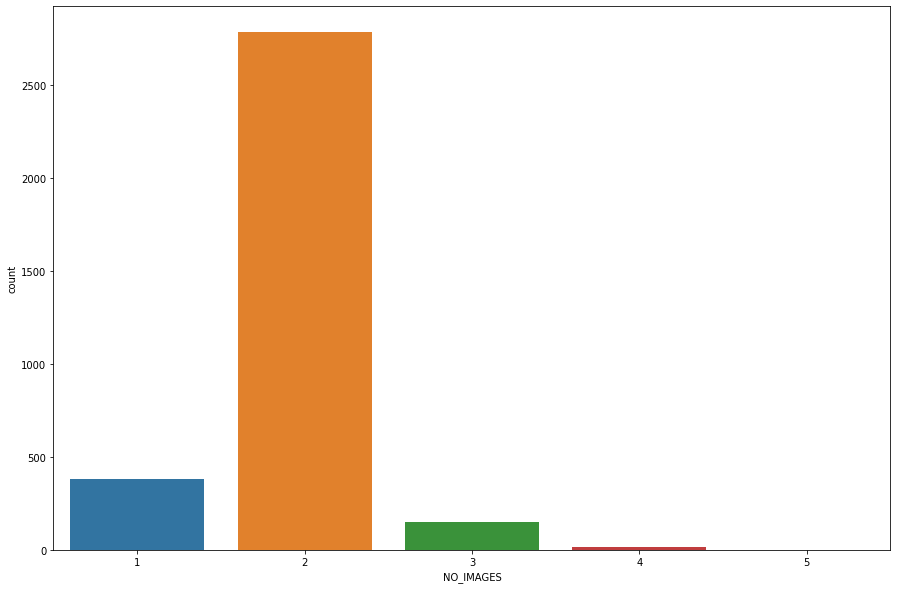

In [ ]:
# code to plot the histogram for the no. of images per report
z = 'NO_IMAGES'
fig, ax = plt.subplots(figsize =(15, 10))
sns.countplot(x=z, data = df_final)

In [ ]:
df_final[z].value_counts()

2    2784
1     382
3     150
4      14
5       1
Name: NO_IMAGES, dtype: int64

__Conclusion: From the Graph we can see that only 2784 reports have both the Images__

In [ ]:
# this function will return the size of an image
def img_res(filename):
    # open an image file and get its resolution
    with Image.open(filename) as image: 
        width, height = image.size 
    # return the image size as 'height X width'
    size = str(height) + 'X' + str(width)
    return size


In [ ]:
# Lets find the resolutions of the image
images = df_final['IMAGES'].values
# This dict will store the image sizes as keys and count as values 
image_dict = dict()
for i in tqdm(images):
    # if more than one images 
    if len(i) > 1:
        # for each image
        for x in i:
            # get size of image 
            path = img_path + '/' + x + '.png'
            size = img_res(path)
            # check if the image size is present in the dict
            if size in image_dict.keys(): 
                val = image_dict[size]
                # if present then increase the count by one 
                image_dict[size] = val + 1
            else:
                # else add the image to the directory
                image_dict[size] = 1
    else:
        # if only one image is present
        # get image size
        path = img_path + '/' + x + '.png'
        size = img_res(path)
        # check if the image size is present in the dict
        if size in image_dict.keys(): 
            val = image_dict[size]
            # if present then increase the count by one 
            image_dict[size] = val + 1
        else:
            # else add the image to the directory
            image_dict[size] = 1

100%|██████████| 3331/3331 [00:11<00:00, 283.45it/s]


In [ ]:
# put the dict in a dataframe
Image_df = pd.DataFrame()
Image_df['Size'] = image_dict.keys()
Image_df['Count'] = image_dict.values()
# print the shape
print(Image_df.shape)
# Now lets sort this 
Image_df.sort_values(by=['Count'], inplace = True, ascending=False)
Image_df.head(20)

(290, 2)


,Size,Count
1,624X512,1836
5,512X512,1315
0,420X512,1173
2,511X512,364
3,618X512,126
4,423X512,96
11,623X512,59
8,613X512,57
16,513X512,56
25,621X512,53


__Conclusion: From the values above we see a lot of variations in the X-Ray Image sizes__ 

##Findings

In [ ]:
# see the count values
df_final[z].value_counts()

2    2784
1     382
3     150
4      14
5       1
Name: NO_IMAGES, dtype: int64

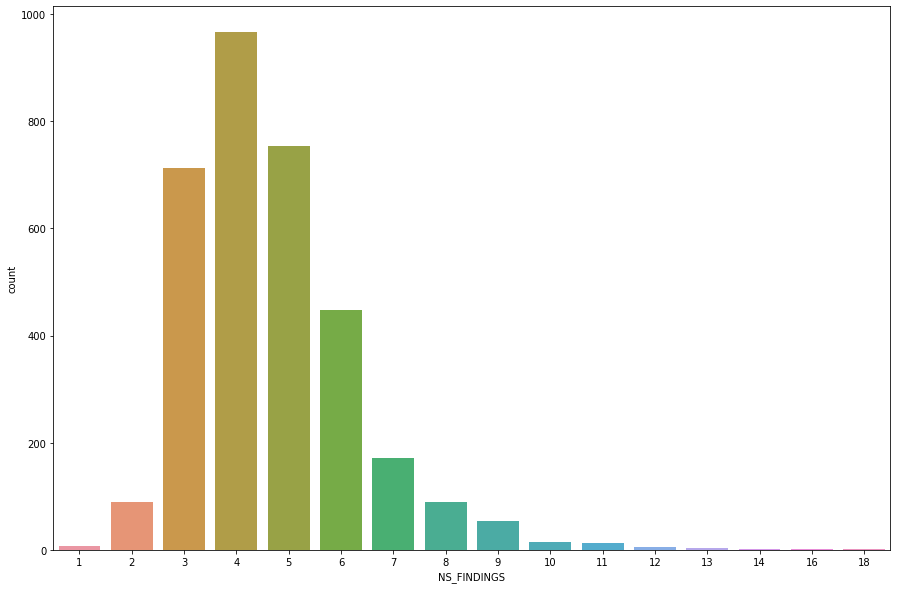

In [ ]:
# code to plot the histogram for the no. of sentences in Findings
z = 'NS_FINDINGS'
fig, ax = plt.subplots(figsize =(15, 10))
sns.countplot(x=z, data = df_final)

__Conclusion: From the above Diagram we see that the number of sentences in Findings ranges from 3 to 7__

In [ ]:
# code to find the most and appearing words in the Findings
# fit a countvectorizer
cv = CountVectorizer(ngram_range=(1, 1))   
cv_fit=cv.fit_transform(df_final.CLEANED_FINDINGS) 
# get words and corresponding counts 
word_list = cv.get_feature_names()   
count_list = cv_fit.toarray().sum(axis=0)  
# create dict from words and counts 
findings_word_freq = dict(zip(word_list,count_list))
# create dataframe from the dict
df_findings_word_freq = pd.DataFrame()
df_findings_word_freq['Words'] = findings_word_freq.keys()
df_findings_word_freq['Count'] = findings_word_freq.values()
# sort the count values and get the top 20 most occuring words 
df_findings_word_freq.sort_values(by=['Count'], inplace = True, ascending=False)
df_findings_word_freq.head(20)

,Words,Count
888,no,4344
901,normal,3442
1030,pleural,2434
1040,pneumothora,2368
445,effusion,2208
599,heart,2108
793,lungs,1942
1266,size,1888
536,focal,1715
1506,within,1498


__Conclusion: From the above table we see the no is the highest occuring word which means that many reports are normal and may not have any abmormalities__

### Impressions

In [ ]:
# see the count values
df_final[z].value_counts()

4     966
5     753
3     713
6     448
7     171
2      90
8      89
9      53
10     14
11     12
1       8
12      6
13      4
18      2
16      1
14      1
Name: NS_FINDINGS, dtype: int64

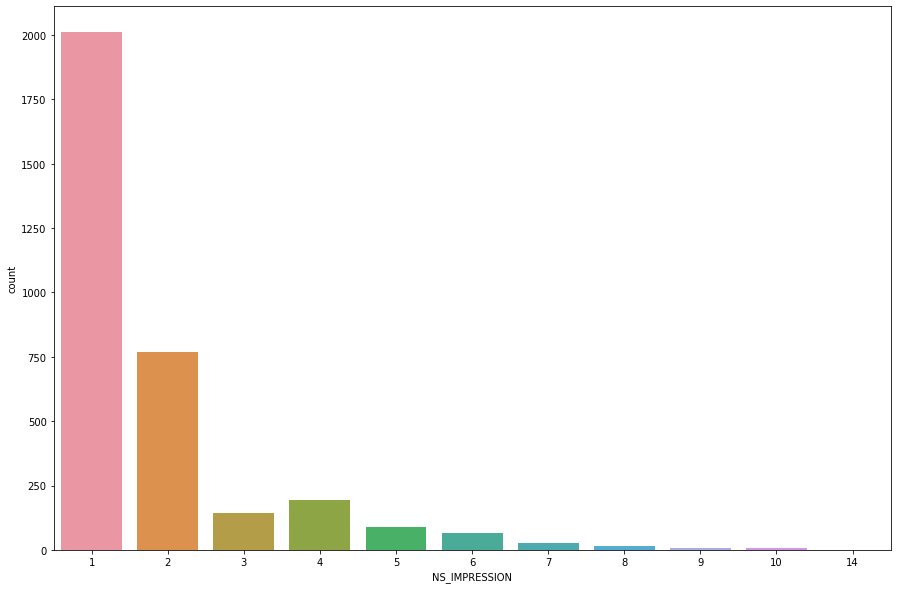

In [ ]:
# code to plot the histogram for the no. of sentences in Impression
z = 'NS_IMPRESSION'
fig, ax = plt.subplots(figsize =(15, 10))
sns.countplot(x=z, data = df_final)

__Conclusion: From the above Diagram we see that the number of sentences in Findings ranges from 1 to 2__

In [ ]:
# code to find the most and least appearing words in the Impression
# fit a countvectorizer
cv = CountVectorizer(ngram_range=(1, 1))   
cv_fit=cv.fit_transform(df_final.CLEANED_IMPRESSION)  
# get words and corresponding counts   
word_list = cv.get_feature_names()   
count_list = cv_fit.toarray().sum(axis=0)   
# create dict from words and counts 
impression_word_freq = dict(zip(word_list,count_list))
# create dataframe from the dict
df_impression_word_freq = pd.DataFrame()
df_impression_word_freq['Words'] = impression_word_freq.keys()
df_impression_word_freq['Count'] = impression_word_freq.values()
# sort the count values and get the top 20 most occuring words 
df_impression_word_freq.sort_values(by=['Count'], inplace = True, ascending=False)
df_impression_word_freq.head(20)

,Words,Count
679,no,2481
14,acute,2198
146,cardiopulmonary,1537
312,disease,959
4,abnormality,752
408,findings,416
843,pulmonary,345
922,right,338
826,process,320
11,active,317


__Conclusion: From the above table we see the no is the highest occuring word which means that many conclusions may not have any abmormalities__

In [ ]:
# save the final dataframe in a csv file
drive_path = '/content/gdrive/My Drive/Assignments_Drive/Case_Study_2/Medical_Data'
cleaned_csv = drive_path + '/cleaned_data.csv'
df_final.to_csv(cleaned_csv)

## Conclusions

- In this Notebook we extracted the text data (Impressions and Findings) from the reports 
- We saw that Many Reports had no Images at all, but most of the reports had 2 X-Ray Images associated with them
- The No. of sentences in the Findings Section ranges from 3-7
- The No. of sentences in the Impression Section Ranges from 1-2
- The Most occuring word in the findings and the impression section is 'no' which may mean that most of the reports in the dataset are of normal chest x-rays without any abnormalities 

## References

- https://github.com/nagapavan525/radiology-report-generation/blob/master/NewIntegrationWithIndication/1_Capstone-Radiology-PreProcessing.ipynb
- https://www.crummy.com/software/BeautifulSoup/bs4/doc/
- https://stackoverflow.com/questions/2612548/extracting-an-attribute-value-with-beautifulsoup
- https://stackoverflow.com/questions/24962673/beautiful-soup-getting-tag-id
- https://stackoverflow.com/a/47091490/4084039
- https://www.appservgrid.com/psam/Python_Samplifier--python1compute--Python_Program_to_Find_the_Size_(Resolution)_of_a_Image.html
- https://www.geeksforgeeks.org/working-images-python/
- https://gist.github.com/sebleier/554280
- https://stackoverflow.com/questions/27488446/how-do-i-get-word-frequency-in-a-corpus-using-scikit-learn-countvectorizer
- https://www.geeksforgeeks.org/python-remove-all-digits-from-a-list-of-strings/
- https://stackoverflow.com/questions/12851791/removing-numbers-from-string
- https://github.com/nagapavan525/radiology-report-generation/blob/master/radiology_report_generation_final/AutomatedRadiologyReportGenerationWithSentenceEmbeddings.ipynb
- https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/